In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# 1. Compare the evolution of RL and NEF values across trials

## 1.1 load values

In [2]:
def load_values(load=False, sessions=[0,1,2,3]):
    if load:
        nef_values = pd.read_pickle("data/nef_values.pkl")
        rl_values = pd.read_pickle("data/rl_values.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        nef_dfs = []
        rl_dfs = []
        for monkey in ['V', 'W']:
            for session in sessions:
                for block in range(1, 25):
                    for trial in range(1, 81):
                        try:
                            file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                            nef_dfs.append(pd.read_pickle(f'data/nef_spikes/{file}_values.pkl'))
                        except:
                            pass
                        try:
                            file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                            rl_dfs.append(pd.read_pickle(f'data/rl/{file}_values.pkl'))
                        except:
                            pass
        nef_values = pd.concat(nef_dfs, ignore_index=True)
        rl_values = pd.concat(rl_dfs, ignore_index=True)
        nef_values.to_pickle("data/nef_values.pkl")
        rl_values.to_pickle("data/rl_values.pkl")
    return nef_values, rl_values

In [3]:
nef_values, rl_values = load_values(load=False, sessions=range(300))

In [4]:
def align_and_combine(nef_values, rl_values):
    nef_values = nef_values.copy()
    rl_values = rl_values.copy()
    nef_values["model_type"] = "nef"
    nef_values['dvs'] = nef_values['va'] - nef_values['vb']
    nef_values['dva'] = nef_values['vl'] - nef_values['vr']
    nef_values['before'] = nef_values['before'].fillna(-1).infer_objects(copy=False)
    nef_values['after'] = nef_values['after'].fillna(-1).infer_objects(copy=False)
    nef_values.rename(columns={'before': 'trial_pre_reversal'}, inplace=True)
    nef_values.rename(columns={'after': 'trial_post_reversal'}, inplace=True)
    nef_values['cloc'] = nef_values['cloc'].replace(0, 'left')
    nef_values['cloc'] = nef_values['cloc'].replace(1, 'right')
    nef_values['clet'] = nef_values['clet'].replace(0, 'A')
    nef_values['clet'] = nef_values['clet'].replace(1, 'B')
    # todo: RPEs

    rl_values["model_type"] = "rl"
    rl_values['dvs'] = rl_values['va'] - rl_values['vb']
    rl_values['dva'] = rl_values['vl'] - rl_values['vr']
    # rl_values['before'] = nef_values['before']
    # rl_values['after'] = nef_values['after']
    # rl_values['block_type'] = nef_values['block_type']
    # rl_values.rename(columns={'V_StimL': 'va'}, inplace=True)
    # rl_values.rename(columns={'V_StimR': 'vb'}, inplace=True)
    # rl_values.rename(columns={'V_Act1': 'vl'}, inplace=True)
    # rl_values.rename(columns={'V_Act2': 'vr'}, inplace=True)
    # rl_values.rename(columns={'omega': 'w'}, inplace=True)
    # rl_values.rename(columns={'DeltaV_Stim': 'dvs'}, inplace=True)
    # rl_values.rename(columns={'DeltaV_Act': 'dva'}, inplace=True)
    # rl_values.rename(columns={'DV_left': 'al'}, inplace=True)
    # rl_values.rename(columns={'DV_right': 'ar'}, inplace=True)
    # rl_values.rename(columns={'chosen location': 'cloc'}, inplace=True)
    # rl_values.rename(columns={'chosen letter': 'clet'}, inplace=True)
    # rl_values.rename(columns={'reward': 'rew'}, inplace=True)
    # rl_values['rew'] = rl_values['rew'].replace(-1, 0)
    # rl_values['cloc'] = rl_values['cloc'].replace(-1, 0)
    # rl_values['clet'] = rl_values['clet'].replace(-1, 0)
    # rl_values['va'] = 2*rl_values['va'] - 1
    # rl_values['vb'] = 2*rl_values['vb'] - 1
    # rl_values['vl'] = 2*rl_values['vl'] - 1
    # rl_values['vr'] = 2*rl_values['vr'] - 1
    # rl_values['al'] = 2*rl_values['al'] - 1
    # rl_values['ar'] = 2*rl_values['ar'] - 1

    combined = pd.concat([rl_values, nef_values], ignore_index=True)
    combined = combined.dropna(axis=1)

    emp = pd.read_pickle("data/empirical.pkl").copy()
    emp['trial_pre_reversal'] = np.where(emp['trial'] < emp['reversal_at_trial'], emp['trial'], None)
    emp['trial_post_reversal'] = np.where(emp['trial'] >= emp['reversal_at_trial'], emp['trial'] - emp['reversal_at_trial'], None)
    emp['trial_pre_reversal'] = emp['trial_pre_reversal'].fillna(-1).infer_objects(copy=False)
    emp['trial_post_reversal'] = emp['trial_post_reversal'].fillna(-1).infer_objects(copy=False)
    emp['model_type'] = 'monkey'
    emp.rename(columns={'monkey_choice': 'cloc'}, inplace=True)
    emp.rename(columns={'monkey_accuracy': 'acc'}, inplace=True)
    emp.rename(columns={'reward': 'rew'}, inplace=True)
    emp['rew'] = emp['rew'].replace(0, -1)
    emp = emp.drop(columns=['left', 'right', 'correct', 'reversal_at_trial'])
    
    combined = pd.concat([rl_values, nef_values, emp], ignore_index=True)

    return combined

In [5]:
combined = align_and_combine(nef_values, rl_values)

/tmp/ipykernel_1146370/3794907580.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nef_values['before'] = nef_values['before'].fillna(-1).infer_objects(copy=False)
/tmp/ipykernel_1146370/3794907580.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nef_values['after'] = nef_values['after'].fillna(-1).infer_objects(copy=False)
/tmp/ipykernel_1146370/3794907580.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to th

In [6]:
combined

,monkey,session,block,trial,reward_seed,block_type,trial_pre_reversal,trial_post_reversal,model_type,va,...,vr,w,al,ar,clet,cloc,rew,acc,dvs,dva
0,V,0,1,1,0.0,what,1,-1,rl,-0.230000,...,-0.230000,0.510000,0.000000,0.000000,A,right,-1,0,-0.230000,0.230000
1,V,0,1,2,0.0,what,2,-1,rl,-0.117300,...,-0.117300,0.510000,0.000000,-0.230000,B,left,1,1,-0.527300,0.527300
2,V,0,1,3,0.0,what,3,-1,rl,-0.059823,...,0.340793,0.537440,0.141077,0.151623,B,right,1,1,-0.711723,-0.131693
3,V,0,1,4,0.0,what,4,-1,rl,-0.030510,...,0.611068,0.547235,0.064570,0.507994,B,right,1,1,-0.825131,-0.504427
4,V,0,1,5,0.0,what,5,-1,rl,-0.015560,...,0.311645,0.572868,0.483127,0.259974,B,left,1,1,-0.894386,0.161274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182395,W,3,2,76,NaN,what,-1,34,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN
1182396,W,3,2,77,NaN,what,-1,35,monkey,NaN,...,NaN,NaN,NaN,NaN,B,right,1,1,NaN,NaN
1182397,W,3,2,78,NaN,what,-1,36,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN
1182398,W,3,2,79,NaN,what,-1,37,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN


## 1.2 Dynamics for single trial (sanity check)

In [7]:
def plot_trial(data, monkey, session, block):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14,4), sharex=True, sharey=True)
    rl = data.query("model_type=='rl' & monkey==@monkey & session==@session & block==@block")
    nef = data.query("model_type=='nef' & monkey==@monkey & session==@session & block==@block")
    fade_let = 0.5 if rl['block_type'].unique()[0]=='where' else 1
    fade_loc = 0.5 if rl['block_type'].unique()[0]=='what' else 1
    sns.lineplot(rl, x='trial', y='va', ax=axes[0][0], color=palette[0], label='va', alpha=fade_let)
    sns.lineplot(rl, x='trial', y='vb', ax=axes[0][0], color=palette[1], label='vb', alpha=fade_let)
    sns.lineplot(rl, x='trial', y='vl', ax=axes[0][0], color=palette[2], label='vl', alpha=fade_loc)
    sns.lineplot(rl, x='trial', y='vr', ax=axes[0][0], color=palette[3], label='vr', alpha=fade_loc)
    sns.lineplot(rl, x='trial', y='w', ax=axes[0][1], color=palette[0])
    sns.lineplot(rl, x='trial', y='al', ax=axes[0][2], color=palette[0], label='al')
    sns.lineplot(rl, x='trial', y='ar', ax=axes[0][2], color=palette[1], label='ar')
    sns.lineplot(rl, x='trial', y='rew', ax=axes[0][3], color=palette[0])
    sns.lineplot(nef, x='trial', y='va', ax=axes[1][0], color=palette[0], label='va', alpha=fade_let)
    sns.lineplot(nef, x='trial', y='vb', ax=axes[1][0], color=palette[1], label='vb', alpha=fade_let)
    sns.lineplot(nef, x='trial', y='vl', ax=axes[1][0], color=palette[2], label='vl', alpha=fade_loc)
    sns.lineplot(nef, x='trial', y='vr', ax=axes[1][0], color=palette[3], label='vr', alpha=fade_loc)
    sns.lineplot(nef, x='trial', y='w', ax=axes[1][1], color=palette[0])
    sns.lineplot(nef, x='trial', y='al', ax=axes[1][2], color=palette[0], label='al')
    sns.lineplot(nef, x='trial', y='ar', ax=axes[1][2], color=palette[1], label='ar')
    sns.lineplot(nef, x='trial', y='rew', ax=axes[1][3], color=palette[0])
    axes[0][1].axhline(0.5, color='k', alpha=0.5)
    axes[1][1].axhline(0.5, color='k', alpha=0.5)
    axes[0][0].set(title='value', ylabel='RL')
    axes[0][1].set(title='omega')
    axes[0][2].set(title='DV')
    axes[0][3].set(title='reward')
    axes[1][0].set(ylabel='NEF')
    fig.tight_layout()
    plt.show()

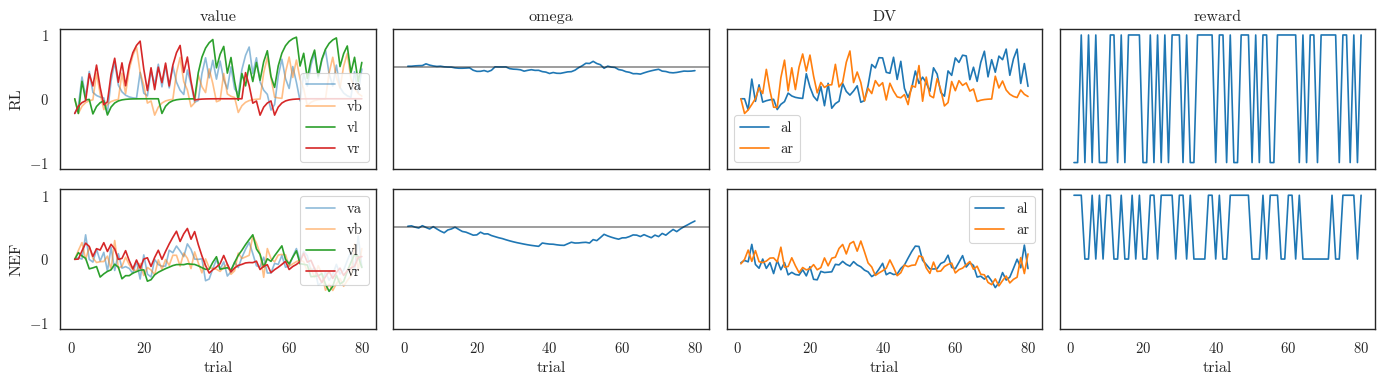

In [8]:
plot_trial(combined, monkey='V', session=0, block=14)

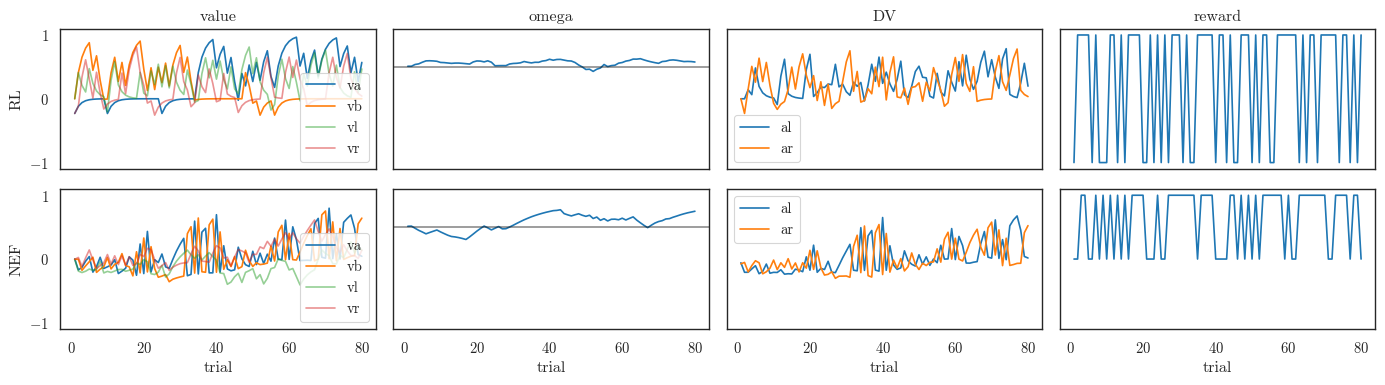

In [9]:
plot_trial(combined, monkey='V', session=0, block=4)

## 1.3 Probability of choosing better option

In [13]:
def get_all_trial_avg_accuracies(df):
    model_types = ['monkey', 'rl', 'nef']
    block_types = ['what', 'where']
    trial_cols = {'pre': 'trial_pre_reversal','post': 'trial_post_reversal'}
    accs = {}
    for model in model_types:
        accs[model] = {}
        for block in block_types:
            accs[model][block] = {}
            for phase, trial_col in trial_cols.items():
                sub_df = df.query(f"model_type == '{model}' and block_type == '{block}' and {trial_col} >= 0 and {trial_col} < 30")
                trial_means = (sub_df.groupby(trial_col)['acc'].mean().sort_index())
                accs[model][block][phase] = trial_means.values  # (T,) array
    return accs

In [14]:
acc_curves = get_all_trial_avg_accuracies(combined)

In [15]:
def compute_rmse_from_curves(acc_curves):
    blocks = ['what', 'where']
    phases = ['pre', 'post']
    rmse = {}
    for block in blocks:
        rmse[block] = {}
        for phase in phases:
            monkey_curve = acc_curves['monkey'][block][phase]
            nef_curve = acc_curves['nef'][block][phase]
            rl_curve = acc_curves['rl'][block][phase]
            rmse[block][phase] = {
                'rl': np.sqrt(np.mean((monkey_curve - rl_curve)**2)),
                'nef':     np.sqrt(np.mean((monkey_curve - nef_curve)**2))
            }
    return rmse

In [16]:
rmses = compute_rmse_from_curves(acc_curves)

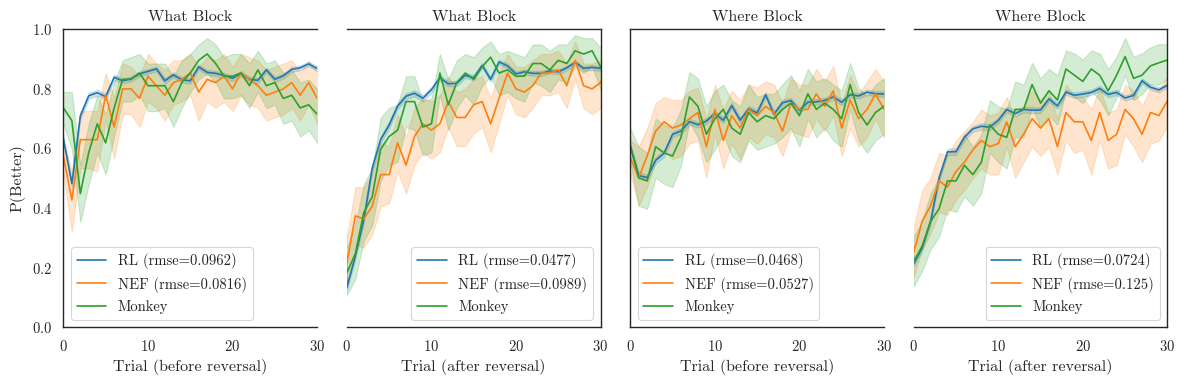

In [17]:
y = 'acc'
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(12, 4))
sns.lineplot(combined_trimmed.query("model_type=='rl' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[0], label=f"RL (rmse={rmses['what']['pre']['rl']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='rl' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[1], label=f"RL (rmse={rmses['what']['post']['rl']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='rl' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[2], label=f"RL (rmse={rmses['where']['pre']['rl']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='rl' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[3], label=f"RL (rmse={rmses['where']['post']['rl']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='nef' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[0], label=f"NEF (rmse={rmses['what']['pre']['nef']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='nef' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[1], label=f"NEF (rmse={rmses['what']['post']['nef']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='nef' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[2], label=f"NEF (rmse={rmses['where']['pre']['nef']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='nef' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[3], label=f"NEF (rmse={rmses['where']['post']['nef']:.3})")
sns.lineplot(combined_trimmed.query("model_type=='monkey' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[0], label='Monkey')
sns.lineplot(combined_trimmed.query("model_type=='monkey' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[1], label='Monkey')
sns.lineplot(combined_trimmed.query("model_type=='monkey' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[2], label='Monkey')
sns.lineplot(combined_trimmed.query("model_type=='monkey' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[3], label='Monkey')
axes[0].legend()
axes[0].set(ylabel="P(Better)", xlabel='Trial (before reversal)', title='What Block', xlim=(0, 30), ylim=(0,1))
axes[1].set(xlabel='Trial (after reversal)', title='What Block')
axes[2].set(xlabel='Trial (before reversal)', title='Where Block')
axes[3].set(xlabel='Trial (after reversal)', title='Where Block')
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
# axes[0].axhline(0.5, color='k')
# axes[1].axhline(0.5, color='k')
# axes[2].axhline(0.5, color='k')
# axes[3].axhline(0.5, color='k')
fig.tight_layout()
# fig.savefig("plots/compare_learning_trajectories.jpg", dpi=600)

## 1.4 Probability of switching action after no reward

In [34]:
combined

,monkey,session,block,trial,reward_seed,block_type,trial_pre_reversal,trial_post_reversal,model_type,va,...,vr,w,al,ar,clet,cloc,rew,acc,dvs,dva
0,V,0,1,1,0.0,what,1,-1,rl,-0.230000,...,-0.230000,0.510000,0.000000,0.000000,A,right,-1,0,-0.230000,0.230000
1,V,0,1,2,0.0,what,2,-1,rl,-0.117300,...,-0.117300,0.510000,0.000000,-0.230000,B,left,1,1,-0.527300,0.527300
2,V,0,1,3,0.0,what,3,-1,rl,-0.059823,...,0.340793,0.537440,0.141077,0.151623,B,right,1,1,-0.711723,-0.131693
3,V,0,1,4,0.0,what,4,-1,rl,-0.030510,...,0.611068,0.547235,0.064570,0.507994,B,right,1,1,-0.825131,-0.504427
4,V,0,1,5,0.0,what,5,-1,rl,-0.015560,...,0.311645,0.572868,0.483127,0.259974,B,left,1,1,-0.894386,0.161274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182395,W,3,2,76,NaN,what,-1,34,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN
1182396,W,3,2,77,NaN,what,-1,35,monkey,NaN,...,NaN,NaN,NaN,NaN,B,right,1,1,NaN,NaN
1182397,W,3,2,78,NaN,what,-1,36,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN
1182398,W,3,2,79,NaN,what,-1,37,monkey,NaN,...,NaN,NaN,NaN,NaN,A,right,-1,0,NaN,NaN


In [53]:
def add_switch_column(data):
    """
    Add a 'switch' column to the DataFrame.
    
    A switch is defined as a change in action after receiving a reward of -1
    on the previous trial, within each (monkey, session, block, model_type) group.
    
    For 'what' blocks, 'clet' is the action column.
    For 'where' blocks, 'cloc' is the action column.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with required columns.
    
    Returns:
        pd.DataFrame: Modified DataFrame with a new 'switch' column.
    """

    # Create action column depending on block_type
    data = data.copy()  # Avoid modifying original
    data['action'] = np.where(data['block_type'] == 'what', data['clet'], data['cloc'])

    # Grouped switch computation
    def compute_switch(group):
        prev_rew = group['rew'].shift(1)
        prev_action = group['action'].shift(1)
        
        switch = np.where(
            prev_rew.isin([-1, 0]),
            (group['action'] != prev_action).astype(int),
            None
        )
        group['switch'] = switch
        return group

    # Apply the computation by group
    result = data.groupby(['monkey', 'session', 'block', 'model_type'], group_keys=False).apply(compute_switch)

    return result

In [54]:
combined_switch = add_switch_column(combined)

/tmp/ipykernel_1146370/2282481436.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = data.groupby(['monkey', 'session', 'block', 'model_type'], group_keys=False).apply(compute_switch)


In [43]:
combined_switch.query("monkey=='V' & session==1 & block==15 & model_type=='monkey'")['action'].to_numpy()

array(['left', 'right', 'left', 'left', 'left', 'right', 'left', 'left',
       'right', 'left', 'left', 'left', 'left', 'left', 'left', 'left',
       'left', 'left', 'left', 'left', 'left', 'left', 'left', 'left',
       'right', 'right', 'right', 'right', 'right', 'right', 'left',
       'left', 'right', 'left', 'left', 'right', 'left', 'left', 'left',
       'right', 'left', 'right', 'right', 'right', 'right', 'right',
       'right', 'right', 'left', 'right', 'right', 'right', 'left',
       'right', 'right', 'right', 'left', 'right', 'right', 'left',
       'right', 'right', 'right', 'right', 'right', 'right', 'right',
       'right', 'right', 'right', 'right', 'right', 'right', 'right',
       'left', 'right', 'right', 'right', 'right', 'right'], dtype=object)

In [44]:
combined_switch.query("monkey=='V' & session==1 & block==15 & model_type=='monkey'")['rew'].to_numpy()

array([ 1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,
        1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,
        1,  1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,
        1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1])

In [45]:
combined_switch.query("monkey=='V' & session==1 & block==15 & model_type=='monkey'")['switch'].to_numpy()

array([None, None, 1, None, None, None, 1, 0, None, 1, None, None, None,
       None, 0, None, 0, 0, None, None, None, None, 0, None, 1, None,
       None, 0, None, 0, 1, None, None, 1, None, 1, 1, 0, 0, 1, 1, 1,
       None, None, None, None, 0, 0, None, 1, None, 0, None, None, 0,
       None, 1, 1, 0, None, 1, None, None, None, None, None, 0, None,
       None, None, 0, None, None, 0, 1, 1, 0, None, 0, None], dtype=object)

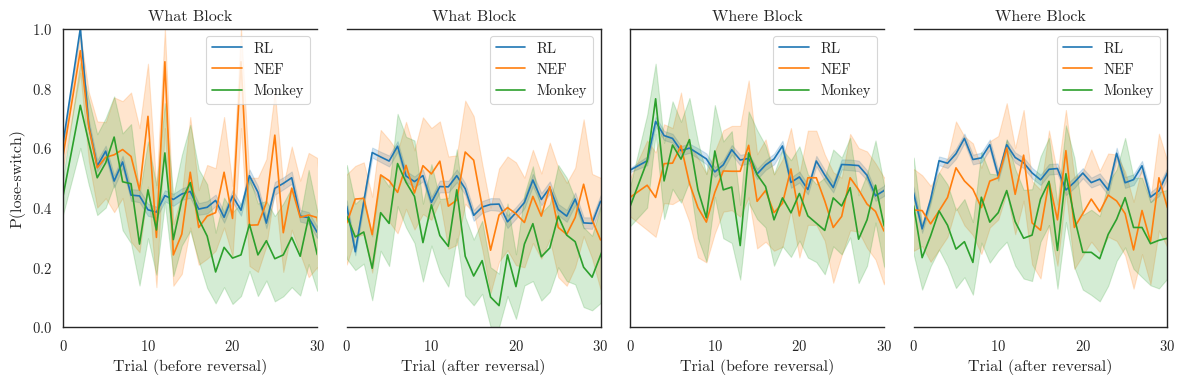

In [55]:
y = 'switch'
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(12, 4))
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[0], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[1], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[0], ax=axes[2], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='rl' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[0], ax=axes[3], label=f"RL")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[0], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[1], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[1], ax=axes[2], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='nef' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[1], ax=axes[3], label=f"NEF")
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='what'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[0], label='Monkey')
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='what'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[1], label='Monkey')
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='where'"), x='trial_pre_reversal', y=y, color=palette[2], ax=axes[2], label='Monkey')
sns.lineplot(combined_switch.query("model_type=='monkey' & block_type=='where'"), x='trial_post_reversal', y=y, color=palette[2], ax=axes[3], label='Monkey')
axes[0].legend()
axes[0].set(ylabel="P(lose-switch)", xlabel='Trial (before reversal)', title='What Block', xlim=(0, 30), ylim=(0,1))
axes[1].set(xlabel='Trial (after reversal)', title='What Block')
axes[2].set(xlabel='Trial (before reversal)', title='Where Block')
axes[3].set(xlabel='Trial (after reversal)', title='Where Block')
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
# axes[0].axhline(0.5, color='k')
# axes[1].axhline(0.5, color='k')
# axes[2].axhline(0.5, color='k')
# axes[3].axhline(0.5, color='k')
fig.tight_layout()
# fig.savefig("plots/compare_learning_trajectories.jpg", dpi=600)